<a href="https://colab.research.google.com/github/HelloKindGit/DA_RNN_PaperReplication/blob/main/A_Dual_Stage_Attention_Based_Recurrent_Neural_Network_for_Time_Series_Prediction_NASDAQ100_Paper_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Project is Made in Google Colab
- Paper: https://arxiv.org/abs/1704.02971

## Imports

In [1]:
#Built-in libraries
import math
import os
import pickle
import random
import re
import urllib.request
import zipfile
from datetime import datetime
from os import listdir
from pathlib import Path
from timeit import default_timer as timer 

#Third-party libraries for data handling and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

#PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

#External PyTorch packages
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
from torchinfo import summary

try: 
    import torchmetrics
except:
    !pip install torchmetrics
    import torchmetrics
from torchmetrics import MeanAbsolutePercentageError as MAPE

#Extra imports
from prettytable import PrettyTable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.3 MB/s eta 0:00:00


In [2]:
#device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

#Data Import

## NASDAQ100

A Dual-Stage Attention-Based Recurrent Neural Network for Time Series Prediction
Qin, Y., Song, D., Cheng, H., Cheng, W., Jiang, G., Cottrell, G.
International Joint Conference on Artificial Intelligence (IJCAI) , 2017
https://cseweb.ucsd.edu/~yaq007/NASDAQ100_stock_data.html

In [3]:
# Setup path to data folder
data_path = Path("Datasets/")
file_path = data_path / "nasdaq_data"

# If the folder doesn't exist, download and extract it
if not file_path.is_dir():
  print(f"Did not find {file_path} directory, creating one and downloading data...")
  file_path.mkdir(parents=True, exist_ok=True)

  data_url = "https://cseweb.ucsd.edu/~yaq007/nasdaq100.zip"
  zip_file_path = data_path / "nasdaq_data.zip"
  urllib.request.urlretrieve(data_url, zip_file_path)

  print("Unzipping data...") 
  with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(file_path)

  os.remove(zip_file_path)
else:
  print(f"{file_path} directory exists.")

Did not find Datasets/nasdaq_data directory, creating one and downloading data...
Unzipping data...


In [4]:
data = pd.read_csv("/content/Datasets/nasdaq_data/nasdaq100/small/nasdaq100_padding.csv")

In [5]:
print(data.shape)
data.head()

(40560, 82)


,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.80,97.80,61.15,95.4000,58.180000,58.00,127.040,26.680,165.8100,...,70.73,45.230,31.1701,95.270,81.365,52.16,33.95,48.61,38.010,4665.054
1,35.9310,96.89,97.80,61.61,95.4115,58.190000,58.12,126.060,26.730,165.9101,...,70.69,45.010,31.1900,94.170,81.540,52.15,34.10,48.74,38.140,4665.054
2,35.9044,96.95,97.57,61.98,95.5100,58.203333,57.95,126.510,26.712,166.1800,...,71.30,45.015,31.2100,94.749,81.530,52.27,34.01,48.99,38.150,4665.826
3,35.8900,96.97,97.55,62.09,95.5200,58.216667,57.96,126.280,26.740,166.1480,...,71.31,45.020,31.2100,94.310,81.710,52.30,33.96,48.95,38.195,4667.081
4,36.0080,96.96,97.73,61.89,95.5300,58.230000,58.21,126.585,26.720,165.9900,...,71.06,45.050,31.1800,94.155,81.720,52.30,34.17,48.89,38.320,4664.491


<Axes: >

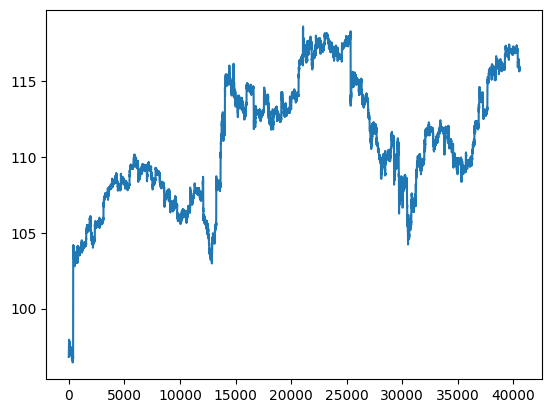

In [6]:
data["AAPL"].plot()

In [7]:
#original numbers from paper
num_timesteps = 10
train_length = 35100
val_length = 2730 #test_length = 2730 -> which means the rest
target_col = "AAPL" #prediction of AAPL data in NASDAQ100
target_shift = -1

#Generate X and y datasets
#formt eine Zeitreihe in ein Format um, das zum Trainieren eines Modells geeignet ist, um 'AAPL' einen Schritt (target_shift) in die Zukunft vorherzusagen; basierend auf den letzten 10 Zeitschritten (num_timesteps) aller Spalten
X = np.stack([data.loc[:, data.columns!=target_col].shift(num_timesteps - t - 1).fillna(method="bfill").values for t in range(num_timesteps)], axis=1)
y_h = np.stack([data[target_col].shift(num_timesteps - t - 1).fillna(method="bfill").values for t in range(num_timesteps)], axis=1)
y_h = np.expand_dims(y_h, axis=-1)
target = data[target_col].shift(target_shift).fillna(method="ffill").values

# Define split function
def split_and_normalize(data):
    data_split = np.split(data, [train_length, train_length + val_length])
    
    #min/max from train split
    data_min, data_max = data_split[0].min(axis=0), data_split[0].max(axis=0)

    data_norm = [(part - data_min) / (data_max - data_min) for part in data_split]
    data_norm = [torch.Tensor(part) for part in data_norm]
    
    return data_norm

# Split and normalize datasets
X_train_t, X_val_t, X_test_t = split_and_normalize(X)
y_h_train_t, y_h_val_t, y_h_test_t = split_and_normalize(y_h)
target_train_t, target_val_t, target_test_t = split_and_normalize(target)

# Create DataLoaders
batch_size = 128
train_dataloader = DataLoader(TensorDataset(X_train_t, y_h_train_t, target_train_t), shuffle=False, batch_size=batch_size)
val_dataloader = DataLoader(TensorDataset(X_val_t, y_h_val_t, target_val_t), shuffle=False, batch_size=batch_size)
test_dataloader = DataLoader(TensorDataset(X_test_t, y_h_test_t, target_test_t), shuffle=False, batch_size=batch_size)


In [8]:
X_train_t.shape, X_val_t.shape, X_test_t.shape, y_h_train_t.shape, y_h_val_t.shape, y_h_test_t.shape, target_train_t.shape, target_val_t.shape, target_test_t.shape

(torch.Size([35100, 10, 81]),
 torch.Size([2730, 10, 81]),
 torch.Size([2730, 10, 81]),
 torch.Size([35100, 10, 1]),
 torch.Size([2730, 10, 1]),
 torch.Size([2730, 10, 1]),
 torch.Size([35100]),
 torch.Size([2730]),
 torch.Size([2730]))

In [9]:
#scaling data to original values -> this will be needed for the plotting later on
data_split = np.split(target, [train_length, train_length + val_length])
#min/max from the training part of the split
target_train_min, target_train_max = data_split[0].min(axis=0), data_split[0].max(axis=0)
print(target_train_min, target_train_max)

96.435 118.6285


# Model
- There are 2 similar Models:
  - A Model with Parameters (nn.Parameter()) -> Doesn't work well for the Predictions (should not be used in this state)
  - A Model with Linear Layers (nn.Linear())
- The Model with the Linear Layers is the improved Version from the Model with Parameters with the Help from ChatGTP

### Encoder / Decoder - Model with Parameters

In [22]:
class InputAttention(nn.Module):
  def __init__(self, T, N, M):
    super(InputAttention, self).__init__()

    self.T = T #number of time steps in the window T
    self.N = N #LSTM input_size
    self.M = M #size of hidden states for the encoder

    self.v_e = nn.Parameter(torch.zeros((self.T, 1)))
    self.W_e = nn.Parameter(torch.zeros((2 * self.M, self.T)))
    self.U_e = nn.Parameter(torch.zeros((self.T, self.T)))

    self.lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)

  def forward(self, X):
    batch_size = X.size(0)
    hidden = torch.zeros((batch_size, self.M)).to(device)
    cell = torch.zeros((batch_size, self.M)).to(device)

    encode = torch.zeros((batch_size, self.T, self.M))

    for t in range(self.T):
      h_c = torch.cat((hidden, cell), dim=1)

      a = (h_c @ self.W_e).unsqueeze(1).expand(-1, self.N, -1)
      b = X.permute(0, 2, 1) @ self.U_e
      
      e_t = (torch.tanh(a + b) @ self.v_e).squeeze()
      a_t = torch.softmax(e_t, dim=1)

      attention_weighted_inputs = a_t * X[:, t, :]

      hidden, cell = self.lstm(attention_weighted_inputs, (hidden, cell))

      encode[:, t, :] = hidden
    return encode

class Encoder(nn.Module):
  def __init__(self, T, N, M):
    super(Encoder, self).__init__()
    self.input_attention = InputAttention(T, N, M).to(device)

  def forward(self, X):
    encoded_X = self.input_attention(X)
    return encoded_X

#--------------------------------------------------------------------

class TemporalAttention(nn.Module):
  def __init__(self, T, P, M):
    super(TemporalAttention, self).__init__()
    self.T = T #number of time steps in the window T
    self.P = P #size of hidden states for the decoder
    self.M = M #size of hidden states for the encoder

    self.v_d = nn.Parameter(torch.zeros((self.M, 1)))
    self.W_d = nn.Parameter(torch.zeros((2*self.P, self.M)))
    self.U_d = nn.Parameter(torch.zeros((self.M, self.M)))

    self.w_tilde = nn.Parameter(torch.zeros((self.M+1, 1)))
    self.W_y = nn.Parameter(torch.zeros((self.P + self.M, self.P)))
    self.v_y = nn.Parameter(torch.zeros((self.P, 1)))

    self.b_tilde = nn.Parameter(torch.zeros((1, 1)))
    self.b_w = nn.Parameter(torch.zeros(1, self.P))
    self.b_v = nn.Parameter(torch.zeros((1, 1)))
    
    self.lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)

  def forward(self, encoded_x, y):
    batch_size = encoded_x.size(0)

    hidden = torch.zeros((batch_size, self.P)).to(device)
    cell = torch.zeros((batch_size, self.P)).to(device)

    for t in range(self.T):
      d_s = torch.cat((hidden, cell), dim=1)

      a = (d_s @ self.W_d).unsqueeze(1).expand(-1, encoded_x.size(1), -1)
      b = encoded_x @ self.U_d
      
      l_t = torch.tanh(a + b) @ self.v_d
      b_t = torch.softmax(l_t, dim=1)
      c_t = torch.sum(b_t * encoded_x, dim=1)

      ct_yt_concat = torch.cat((c_t, y[:, t, :]), dim=1)
      y_t_tilde = ct_yt_concat @ self.w_tilde + self.b_tilde
      hidden, cell = self.lstm(y_t_tilde, (hidden, cell))
    
    hidden_ct_concat = torch.cat((hidden, c_t), dim=1)
    c = (hidden_ct_concat @ self.W_y + self.b_w)
    y_T = c @ self.v_y + self.b_v
    return y_T

class Decoder(nn.Module):
  def __init__(self, T, P, M):
    super(Decoder, self).__init__()
    self.temporal_attention = TemporalAttention(T, P, M)

  def forward(self, X_tilde, y):
    y_decoded = self.temporal_attention(X_tilde, y).to(device)
    return y_decoded

### Encoder / Decoder - Model with Linear Layers

In [25]:
class InputAttention(nn.Module):
  def __init__(self, T, N, M):
    super(InputAttention, self).__init__()

    self.T = T #number of time steps in the window T
    self.N = N #LSTM input_size
    self.M = M #size of hidden states for the encoder

    self.v_e = nn.Linear(in_features=self.T, out_features=1)
    self.W_e = nn.Linear(in_features=2 * self.M, out_features=self.T)
    self.U_e = nn.Linear(in_features=self.T, out_features=self.T)

    self.lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)

  def forward(self, X):
    batch_size = X.size(0)
    hidden = torch.zeros((batch_size, self.M)).to(device)
    cell = torch.zeros((batch_size, self.M)).to(device)

    encode = torch.zeros((batch_size, self.T, self.M))

    for t in range(self.T):
      h_c = torch.cat((hidden, cell), dim=1)

      a = self.W_e(h_c).unsqueeze(1).expand(-1, self.N, -1)
      b = self.U_e(X.permute(0, 2, 1))
      
      e_t = self.v_e(torch.tanh(a + b)).squeeze()
      a_t = torch.softmax(e_t, dim=1)

      hidden, cell = self.lstm(a_t * X[:, t, :], (hidden, cell))

      encode[:, t, :] = hidden
    return encode

class Encoder(nn.Module):
  def __init__(self, T, N, M):
    super(Encoder, self).__init__()
    self.input_attention = InputAttention(T, N, M)

  def forward(self, X):
    encoded_X = self.input_attention(X)
    return encoded_X

#--------------------------------------------------------------------

class TemporalAttention(nn.Module):
  def __init__(self, T, P, M):
    super(TemporalAttention, self).__init__()
    self.T = T #number of time steps in the window T
    self.P = P #size of hidden states for the decoder
    self.M = M #size of hidden states for the encoder

    self.v_d = nn.Linear(in_features=self.M, out_features=1)
    self.W_d = nn.Linear(in_features=2*self.P, out_features=self.M)
    self.U_d = nn.Linear(in_features=self.M, out_features=self.M)

    self.w_tilde = nn.Linear(in_features=self.M + 1, out_features=1)
    self.W_y = nn.Linear(in_features=self.P + self.M, out_features=self.P)
    self.v_y = nn.Linear(in_features=self.P, out_features=1)
    
    self.lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)

  def forward(self, encoded_x, y):
    batch_size = encoded_x.size(0)

    hidden = torch.zeros((batch_size, self.P)).to(device)
    cell = torch.zeros((batch_size, self.P)).to(device)

    for t in range(self.T):
      d_s = torch.cat((hidden, cell), dim=1)

      a = self.W_d(d_s).unsqueeze(1).expand(-1, encoded_x.size(1), -1)
      b = self.U_d(encoded_x)
      
      l_t = self.v_d(torch.tanh(a + b))
      b_t = torch.softmax(l_t, dim=1)
      c_t = torch.sum(b_t * encoded_x, dim=1)

      ct_yt_concat = torch.cat((c_t, y[:, t, :]), dim=1)
      y_t_tilde = self.w_tilde(ct_yt_concat)
      hidden, cell = self.lstm(y_t_tilde, (hidden, cell))
    
    hidden_ct_concat = torch.cat((hidden, c_t), dim=1)
    c = self.W_y(hidden_ct_concat)
    y_T = self.v_y(c)
    return y_T

class Decoder(nn.Module):
  def __init__(self, T, P, M):
    super(Decoder, self).__init__()
    self.temporal_attention = TemporalAttention(T, P, M)

  def forward(self, X_tilde, y):
    y_decoded = self.temporal_attention(X_tilde, y)
    return y_decoded

In [26]:
#@title Complete Model
class DualStage_Attention_RNN(nn.Module):
  def __init__(self, N, M, P, T):
    super(DualStage_Attention_RNN, self).__init__()

    self.N = N #LSTM input_size
    self.M = M #size of hidden states for the encoder
    self.P = P #size of hidden states for the decoder
    self.T = T #number of time steps in the window T

    self.encoder = Encoder(T, N, M).to(device)
    self.decoder = Decoder(T, P, M).to(device)

  def forward(self, x, y):
    encoded_X = self.encoder(x)
    output = self.decoder(encoded_X, y)
    #print('Final Output Shape', output.shape)
    return output

### Model Architecture



In [ ]:
dsa_rnn_model = DualStage_Attention_RNN(81, 64, 64, 10)
summary(dsa_rnn_model, [(128, 10, 81), (128, 10, 1)]) #test pass through of an example input

In [ ]:
def print_model_summary(model):
    table = PrettyTable(["Layer", "Size", "Parameters"])
    total_params = 0
    print("Model Summary:")
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        size = param.size()
        params = param.numel()
        table.add_row([name, size, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

print_model_summary(dsa_rnn_model)

In [15]:
#@title Tensorboard Tracking
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None):
  timestamp = datetime.now().strftime("%Y-%m-%d")
  log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

  if extra:
      log_dir = os.path.join(log_dir, extra)
      
  print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
  return SummaryWriter(log_dir=log_dir)

In [16]:
#@title Saving Model
#https://www.learnpytorch.io/05_pytorch_going_modular/#5-creating-a-function-to-save-the-model-utilspy
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  #Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  #Create model save path
  if not model_name.endswith(".pth") and not model_name.endswith(".pt"):
    raise ValueError("model_name should end with '.pt' or '.pth'")
  model_save_path = target_dir_path / model_name

  #Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

# Model Fitting

In [17]:
#@title Train Loop
def training(model: torch.nn.Module, 
             dataloader: torch.utils.data.DataLoader, 
             loss_fn: torch.nn.Module, 
             optimizer: torch.optim.Optimizer,
             eval_metrics):
  #train mode
  model.train()
  train_loss = 0

  #metrics
  train_metrics = [0, 0, 0]
  
  for batch, (X, y_h, y) in enumerate(dataloader):
    X, y_h, y = X.to(device), y_h.to(device), y.to(device)

    y_preds = model(X, y_h).squeeze(1)

    loss = loss_fn(y_preds, y)
    train_loss += loss.item()

    for i, t_met in enumerate(eval_metrics):
      err = t_met(y_preds, y)
      train_metrics[i] += err.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  for i in range(len(train_metrics)):
    train_metrics[i] /= len(dataloader)

  train_loss /= len(dataloader)
  return train_loss, train_metrics

In [18]:
#@title Validation Loop
def validating(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               eval_metrics):
  #eval mode
  model.eval()
  val_loss = 0

  #metrics
  val_metrics = [0, 0, 0]
  
  with torch.inference_mode():
    for batch, (X, y_h, y) in enumerate(dataloader):
      X, y_h, y = X.to(device), y_h.to(device), y.to(device)

      val_preds = model(X, y_h).squeeze(1)

      loss = loss_fn(val_preds, y)
      val_loss += loss.item()

      for i, e_met in enumerate(eval_metrics):
        err = e_met(val_preds, y)
        val_metrics[i] += err.item()

  for i in range(len(val_metrics)):
    val_metrics[i] /= len(dataloader)

  val_loss /= len(dataloader)
  return val_loss, val_metrics

In [19]:
#@title Testing Loop
def testing(model: torch.nn.Module, 
            dataloader: torch.utils.data.DataLoader, 
            loss_fn: torch.nn.Module):
  #eval mode
  model.eval()
  test_loss = 0

  #for plotting
  true, preds = [], []
  
  with torch.inference_mode():
    for batch, (X, y_h, y) in enumerate(dataloader):
      X, y_h, y = X.to(device), y_h.to(device), y.to(device)

      test_preds = model(X, y_h)

      loss = loss_fn(test_preds.squeeze(1), y)
      test_loss += loss.item()

      true.append(y.detach().cpu().numpy())
      preds.append(test_preds.detach().cpu().numpy())

  out_true, out_preds = np.concatenate(true), np.concatenate(preds)
      
  test_loss /= len(dataloader)
  return test_loss, out_true, out_preds

In [20]:
#@title Main Fit Loop
def fit(model: torch.nn.Module, 
        train_dataloader: torch.utils.data.DataLoader, 
        val_dataloader: torch.utils.data.DataLoader, 
        optimizer: torch.optim.Optimizer,
        lr_scheduler: torch.optim.lr_scheduler,
        loss_fn: torch.nn.Module,
        epochs: int,
        eval_metrics,
        writer: torch.utils.tensorboard.writer.SummaryWriter):
  #result dictionary
  results = {
      "train_loss": [],
      "val_loss": []
      }
  
  for epoch in tqdm(range(epochs)):
    train_loss, train_metrics = training(model=model,
                          dataloader=train_dataloader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          eval_metrics=eval_metrics)
      
    val_loss, val_metrics = validating(model=model,
                        dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        eval_metrics=eval_metrics)
    
    #Update learning rate
    lr_scheduler.step()
    
    if epoch % 5 == 0:
      print(f"Epoch: {epoch} | Train_Loss: {train_loss:.5f} | Val_Loss: {val_loss:.5f}")

    #Store losses
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)

    #Save metrics to TensorBoard
    if writer:
      #Add results to SummaryWriter
      writer.add_scalars(main_tag="Loss", 
                         tag_scalar_dict={"train_loss": train_loss,
                                          "val_loss": val_loss},
                         global_step=epoch)
      
      writer.add_scalars(main_tag="Evaluation Metrics", 
                         tag_scalar_dict={"train_RMSE": train_metrics[0],
                                          "train_MAE": train_metrics[1],
                                          "train_MAPE": train_metrics[2],
                                          "val_RMSE": val_metrics[0],
                                          "val_MAE": val_metrics[1],
                                          "val_MAPE": val_metrics[2]},
                         global_step=epoch)
      writer.close()

  return results

In [21]:
#@title RMSE Loss Function
#https://discuss.pytorch.org/t/rmse-loss-function/16540/2
def RMSELoss(y_pred,y):
  assert y_pred.size() == y.size(), "Expected y_pred and y to have the same size"
  return torch.sqrt(torch.mean((y_pred-y)**2))

In [ ]:
#@title Fitting
#Set random seeds
torch.manual_seed(10) 
torch.cuda.manual_seed(10)

EPOCHS = 30 #should be at least 30-50 epochs to see actual results

N = X_train_t.shape[2] #81
M = P = 64 #or 128
T = 10 #Dataset 'num_timesteps' would need to be changed first before T can be changed

#Instantiate the model
dsa_rnn_model = DualStage_Attention_RNN(N, M, P, T).to(device)

#Define loss function and optimizer with learning rate decay
loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=dsa_rnn_model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=15, gamma=0.8) #in the paper it's 10 % every 10.000 iterations

#Evaluation Metrics
eval_metrics = [RMSELoss, nn.L1Loss(), MAPE()]

#Start timer
start = timer()

#Fit model
model_results = fit(model=dsa_rnn_model, 
                    train_dataloader=train_dataloader,
                    val_dataloader=val_dataloader,
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    loss_fn=loss_fn, 
                    epochs=EPOCHS,
                    eval_metrics=eval_metrics,
                    writer=create_writer(experiment_name='NASDAQ100', model_name='dsa_rnn_model'))

print(f"Total fitting time: {timer()-start:.3f} seconds")
#print(model_results)

In [ ]:
#Viewing TensorBoard in Jupyter and Google Colab Notebooks
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
#@title Test Data and Plotting
test_loss, true_values, predicted_values = testing(model=dsa_rnn_model,
                                                   dataloader=test_dataloader,
                                                   loss_fn=loss_fn)

#scale up the values -> they were downscaled at the beginning
true_values = true_values*(target_train_max - target_train_min) + target_train_min
predicted_values = predicted_values*(target_train_max - target_train_min) + target_train_min

# Plotting
plt.figure(figsize=(18, 9))
plt.title(f'[NASDAQ100] Time Series - Test Loss: {test_loss:.5f}')
plt.xlabel('Number of Samples')
plt.ylabel('Price')
plt.plot(true_values, color='green', label='True')
plt.plot(predicted_values, color='red', label='Predicted')
plt.legend(loc="upper left")
plt.show()

In [ ]:
#@title Experiment Tracking (This will take a long time)
#Set random seeds
torch.manual_seed(10) 
torch.cuda.manual_seed(10)

#Experiment Parameters - These are the most important parameters from this paper
num_EPOCHS = [1, 5, 10]
N = X_train_t.shape[2] #81
M_P_params = [16, 32, 64]
T = 10 #can't be changed that easily -> the dataset is preprocessed with T = 10

#start experiments
for experiment_num, epoch in enumerate(num_EPOCHS, start=1):
  for m_p_param in M_P_params:

      print(f"[INFO] Experiment number: {experiment_num}")
      print(f"[INFO] M_P-Parameters: {m_p_param}")
      print(f"[INFO] Number of epochs: {epoch}")  

      #Instantiate the model
      dsa_rnn_model = DualStage_Attention_RNN(N, m_p_param, m_p_param, T).to(device)

      #Define loss function and optimizer with learning rate decay
      loss_fn = nn.MSELoss()
      optimizer = optim.Adam(params=dsa_rnn_model.parameters(), lr=0.001)
      lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=15, gamma=0.8)

      #Evaluation Metrics
      eval_metrics = [RMSELoss, nn.L1Loss(), MAPE()]

      #start timer
      start = timer()

      fit(model=dsa_rnn_model, 
          train_dataloader=train_dataloader,
          val_dataloader=val_dataloader,
          optimizer=optimizer,
          lr_scheduler=lr_scheduler,
          loss_fn=loss_fn, 
          epochs=epoch,
          eval_metrics=eval_metrics,
          writer=create_writer(experiment_name='NASDAQ100', model_name='dsa_rnn_model', extra=f"{epoch}_epochs"))

      print(f"Total fitting time: {timer()-start:.3f} seconds")

      #save model state_dict
      save_filepath = f"dsa_rnn_model_NASDAQ100_{epoch}_epochs.pth"
      save_model(model=dsa_rnn_model,
                 target_dir="models",
                 model_name=save_filepath)
      print("-"*35 + "\n")

In [ ]:
#Viewing TensorBoard in Jupyter and Google Colab Notebooks
#%load_ext tensorboard
#%tensorboard --logdir runs

In [ ]:
#@title Load the best model
# Setup the best model filepath
model_path = ".pth" #Path needs to be filled in
#create model with correct parameters
model = DualStage_Attention_RNN() #Correct parameters need to be filled in
#load model state_dict
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Model loaded successfully!")
except FileNotFoundError:
    print("Model file not found.")

test_loss, true_values, predicted_values = testing(model=model,
                                                   dataloader=test_dataloader,
                                                   loss_fn=loss_fn)

#scale up the values -> they were downscaled at the beginning
true_values = true_values*(target_train_max - target_train_min) + target_train_min
predicted_values = predicted_values*(target_train_max - target_train_min) + target_train_min

# Plotting
plt.figure(figsize=(18, 9))
plt.title(f'[NASDAQ100] Time Series - Test Loss: {test_loss:.5f}')
plt.xlabel('Number of Samples')
plt.ylabel('Price')
plt.plot(true_values, color='green', label='True')
plt.plot(predicted_values, color='red', label='Predicted')
plt.legend(loc="upper left")
plt.show()